# Elo Merchant Category Recommendation

## Description

Elo is one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders.

**Goal** - predict the loyalty score per card ID. It will serve to understand individual shopping patterns in order to create personalised recommendations/promotions, reduce unwanted campaigns and to create the right experience for customers.


**target** - loyalty numerical score calculated 2 months after historical and evaluation period

### The data

**train.csv** and **test.csv** contain card_ids and information about the card itself - the first month the card was active, etc.

**historical_transactions.csv** - 3 months' worth of transactions for every card at any of the provided merchant_ids.

**new_merchant_transactions.csv** - the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) over a period of two months.

**merchants.csv** - can be joined with the transaction sets to provide additional merchant-level information.

### Imports

In [2]:
#autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2
#include matplotlib graphs in the notebook
%matplotlib inline


In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import gc

In [4]:
import xgboost as xgb
import lightgbm as lgb 
from sklearn.model_selection import KFold

In [5]:
#specify from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import gcwhere the data is located
PATH = "C:\\Users\\Agata\\fastai\\courses\\ml1\\data\\elo\\"

### Reading the data

#### Data sets

- train.csv - the training set
- test.csv - the test set
- historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
- merchants.csv - additional information about all merchants / merchant_ids in the dataset.
- new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.


#### Historical transactions/ new transactions

In [5]:
historical_transactions = pd.read_csv(f'{PATH}historical_transactions.csv', parse_dates=["purchase_date"])
new_transactions = pd.read_csv(f'{PATH}new_merchant_transactions.csv', parse_dates=["purchase_date"])

In [6]:
print(f'Number of rows and columns in historical_transactions set {historical_transactions.shape}')
print(f'Number of rows and columns in new_transactions set {new_transactions.shape}')

Number of rows and columns in historical_transactions set (29112361, 14)
Number of rows and columns in new_transactions set (1963031, 14)


In [7]:
historical_transactions.head(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,-0.734887,2018-02-24 08:45:05,1.0,9,37
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,-0.716855,2017-03-21 00:10:51,1.0,16,37
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,-0.657049,2017-11-18 20:05:55,1.0,16,37
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,-0.737967,2017-06-01 22:02:56,1.0,16,37
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,-0.715352,2017-03-16 15:41:22,1.0,16,37


In [8]:
historical_transactions.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
authorized_flag,29112361,2,Y,26595452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card_id,29112361,325540,C_ID_3d3dfdc692,5582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city_id,2.91124e+07,NaN,NaN,NaN,NaN,NaN,129.326,104.256,-1,53,90,212,347
category_1,29112361,2,N,27028332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installments,2.91124e+07,NaN,NaN,NaN,NaN,NaN,0.648495,2.79558,-1,0,0,1,999
category_3,28934202,3,A,15411747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
merchant_category_id,2.91124e+07,NaN,NaN,NaN,NaN,NaN,481.013,249.376,-1,307,454,705,891
merchant_id,28973880,326311,M_ID_00a6ca8a8a,1115097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month_lag,2.91124e+07,NaN,NaN,NaN,NaN,NaN,-4.48729,3.5888,-13,-7,-4,-2,0
purchase_amount,2.91124e+07,NaN,NaN,NaN,NaN,NaN,0.0364009,1123.52,-0.746908,-0.720356,-0.688349,-0.603254,6.0106e+06


#### Processing the date
The purchase date has been transformed into the numerical/boolean variables from attr list

In [9]:
def process_date(df, fld_name, drop=True):
    fld = df[fld_name]
    targ_pre = re.sub('[Dd]ate$', '', fld_name)
    #df[targ_pre + "Year"] = df[fld_name].dt.year
    attr = ['Year', 'Month', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df['month_diff'] = ((datetime.datetime.today() - df[fld_name]).dt.days)//30
#    df['month_diff'] += df['month_lag']
    if drop: df.drop(fld_name, axis=1, inplace=True)

In [10]:
process_date(historical_transactions, 'purchase_date')

In [11]:
process_date(new_transactions, 'purchase_date')

In [12]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,purchase_Month,purchase_Dayofweek,purchase_Dayofyear,purchase_Is_month_end,purchase_Is_month_start,purchase_Is_quarter_end,purchase_Is_quarter_start,purchase_Is_year_end,purchase_Is_year_start,month_diff
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,...,3,6,70,False,False,False,False,False,False,11
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,...,3,0,78,False,False,False,False,False,False,11
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,...,4,3,116,False,False,False,False,False,False,10
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,...,3,2,66,False,False,False,False,False,False,11
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,...,3,3,81,False,False,False,False,False,False,11


**Convert categorical variables**

In [13]:
# check which variables are not numeric
l=[]
for label, col in historical_transactions.items():
    if not pd.api.types.is_numeric_dtype(col):
        l.append(label)
print(l)
    

['authorized_flag', 'card_id', 'category_1', 'category_3', 'merchant_id']


In [14]:
# transform two columns into numerical variables based on dictionary
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [15]:
# check the distribution of category 3
print(historical_transactions['category_3'].value_counts())

A    15411747
B    11677522
C     1844933
Name: category_3, dtype: int64


In [16]:
# check the types of all variables
print(historical_transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 24 columns):
authorized_flag              int64
card_id                      object
city_id                      int64
category_1                   int64
installments                 int64
category_3                   object
merchant_category_id         int64
merchant_id                  object
month_lag                    int64
purchase_amount              float64
category_2                   float64
state_id                     int64
subsector_id                 int64
purchase_Year                int64
purchase_Month               int64
purchase_Dayofweek           int64
purchase_Dayofyear           int64
purchase_Is_month_end        bool
purchase_Is_month_start      bool
purchase_Is_quarter_end      bool
purchase_Is_quarter_start    bool
purchase_Is_year_end         bool
purchase_Is_year_start       bool
month_diff                   int64
dtypes: bool(6), float64(2), int64(13), obje

In [17]:
#version with dictionary to control the categories
# right now it is a list of tuples not a dict
# maybe in the future add dict as input to the function
def cat_converter(df, ignore=[]):
    """
    Maping of categorical variables into codes
    df: Pandas dataframe
    ignore: list of columns ignored when converting
    """
    d =[]
    for label, col in df.items():
        if not pd.api.types.is_numeric_dtype(col) and label not in ignore:
            df[label] = df[label].astype('category').cat.as_ordered()
            d.append(list(enumerate(df[label].cat.categories)))
            df[label]=df[label].cat.codes+1
    return df, d

In [18]:
historical_transactions, d =cat_converter(historical_transactions, ["merchant_id", "card_id"])

In [19]:
# check the mapping for historical transactions
print(d)

[[(0, 'A'), (1, 'B'), (2, 'C')]]


In [20]:
new_transactions, d2 =cat_converter(new_transactions, ["merchant_id", "card_id"])

In [21]:
# chaeck the mapping for new transactions. It should match the other tables for consistency/ interpretation purposes.
print(d2)

[[(0, 'A'), (1, 'B'), (2, 'C')]]


In [22]:
#old version of this function without returning the dict
def cat_converter(df, ignore=[]):
    """
    Maping of categorical variables into codes
    df: Pandas dataframe
    ignore: list of columns ignored when converting
    """
    for label, col in df.items():
        if not pd.api.types.is_numeric_dtype(col) and label not in ignore:
            df[label] = df[label].astype('category').cat.codes+1
    return df

In [28]:
#historical_transactions=cat_converter(historical_transactions, ["merchant_id", "card_id"])
#new_transactions=cat_converter(new_transactions, ["merchant_id", "card_id"])


In [20]:
#checking variable types
historical_transactions.dtypes

authorized_flag                int64
card_id                       object
city_id                        int64
category_1                     int64
installments                   int64
category_3                      int8
merchant_category_id           int64
merchant_id                   object
month_lag                      int64
purchase_amount              float64
category_2                   float64
state_id                       int64
subsector_id                   int64
purchase_Year                  int64
purchase_Month                 int64
purchase_Dayofweek             int64
purchase_Dayofyear             int64
purchase_Is_month_end           bool
purchase_Is_month_start         bool
purchase_Is_quarter_end         bool
purchase_Is_quarter_start       bool
purchase_Is_year_end            bool
purchase_Is_year_start          bool
month_diff                     int64
dtype: object

How many authorised transactions are there on average per card_id



In [21]:
agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)


In [22]:
auth_mean.head()

,card_id,authorized_flag_mean
0,C_ID_00007093c1,0.765101
1,C_ID_0001238066,0.975610
2,C_ID_0001506ef0,0.939394
3,C_ID_0001793786,0.875000
4,C_ID_000183fdda,0.951389


Divide the historical transactions into authorised and unathorised

In [22]:
authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
non_authorised = historical_transactions[historical_transactions['authorized_flag'] == 0]

#### Two way frequency table (continegency table)
for each card_id calculate how amny transaction it has done with each merchant_id

In [23]:
a1=historical_transactions.groupby(["card_id","merchant_id"]).size().reset_index(name='count_merchant')


In [24]:
a1.columns

Index(['card_id', 'merchant_id', 'count_merchant'], dtype='object')

In [25]:
type(a1)

pandas.core.frame.DataFrame

For each card_id calculate how many times it transacted with each merchant

Take max of transaction count per merchant_id => this variable will capture if card_id has one merchant for which it is loyal to

(Take std dev of transaction count per merchant_id => this variable will capture  the diversity of shopping behaviours. Is this card used frequently with many merchants?)

Count how many merchant_ids with only one transaction => this will show if the customer is using the card with many new merchants often=> sign of not a loyal customer => will be the same as count unique merchants

Calculate the average of counts per merchant_id=> how many times per average the customer is transacting with one merchant


In [26]:
aggregations = {
    'count_merchant':['max', 'min', 'std', 'mean', 'skew']   
}
#, lambda x: sum(x==1)

In [27]:
a2=a1.groupby(["card_id"]).agg(aggregations)

In [28]:
#a2

In [29]:
a2.columns = ['_'.join(col).strip() for col in a2.columns.values]
a2.reset_index(inplace=True)

In [31]:
#a2

In [32]:
#a2.rename(columns={"count_<lambda>": "count_unique_merchants"})

#### Trying to capture monthly changes

In [25]:
#monthly_changes=historical_transactions.groupby(["card_id","month_diff"], as_index=False).agg({"purchase_amount": "sum"})

In [26]:
#aggr={'purchase_amount': ['mean', 'max', 'min', 'std', 'skew']}

In [27]:
#monthly_changes=monthly_changes.groupby(["card_id"]).agg(aggr)

In [28]:
#monthly_changes.columns = ['monthly_'+'_'.join(col).strip() for col in monthly_changes.columns.values]

In [29]:
#monthly_changes.reset_index(inplace=True)
#monthly_changes.head()

,card_id,monthly_purchase_amount_mean,monthly_purchase_amount_max,monthly_purchase_amount_min,monthly_purchase_amount_std,monthly_purchase_amount_skew
0,C_ID_00007093c1,-5.911157,-3.449005,-13.924633,2.728041,-2.340388
1,C_ID_0001238066,-12.074534,-1.302784,-20.930714,6.918579,0.514952
2,C_ID_0001506ef0,-2.661683,0.518324,-10.350231,2.850964,-1.651936
3,C_ID_0001793786,-3.678601,2.123817,-12.087822,4.464679,-0.666478
4,C_ID_000183fdda,-9.833991,-0.942222,-15.991920,5.409421,0.869736


In [30]:
#monthly_changes.drop('monthly_purchase_amount_mean', inplace=True, axis=1)

#### The rate of change of amounts spent which each merchant
1. group tranasactions by "month_diff", "card_id", "merchant_id", keep purchase amount
2. calculate the percent change in each group card_id, merchant_id -> how client behaviour changes with that merchant over time 

In [31]:
#historical_transactions['pct_ch'] = historical_transactions.groupby(["card_id","merchant_id","month_diff"])["purchase_amount"].pct_change() + 1

In [32]:
#d1 = historical_transactions.set_index(["month_diff", "card_id", "merchant_id"])[['purchase_amount']]


In [33]:
#type(d1)

In [34]:
#d2 = d1.groupby(level=["card_id", "merchant_id"]).agg({'purchase_amount': lambda x: d1.pct_change(x)})
#print(d2)

In [35]:
#historical_transactions.groupby(["card_id","month_diff"])["purchase_amount"].mean().pct_change() + 1

In [71]:
#historical_transactions["pct_ch"].fillna(value=1, inplace=True)

In [36]:
#historical_transactions[historical_transactions["pct_ch"]==historical_transactions["pct_ch"].max()]

In [37]:
#aggr={'pct_ch': ['mean', 'max', 'min', 'std', 'nunique', 'skew']}

In [38]:
#monthly_merchant_changes = historical_transactions.groupby(["card_id"]).agg(aggr)

In [39]:
#monthly_merchant_changes.columns = ['_'.join(col).strip() for col in monthly_merchant_changes.columns.values ]

In [40]:
#monthly_merchant_changes.reset_index(inplace=True)

In [41]:
#monthly_merchant_changes.describe()

**Aggragations**

Agrragate by grouping by card_id.

In [30]:
def aggregate(df, fldname, agg_func):
    """
    This function aggregates the data
    
    variables
    df: Pandas dataframe
    fldname: name of the column to group by
    agg_funct: a dictionary maping the columns and agregation functions
    
    
    """
    agg_df = df.groupby([fldname]).agg(agg_func)
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    #count the number of transactions per card_id
    transactions_number = (df.groupby(fldname)
          .size()
          .reset_index(name='transactions_count'))
    
    #join the results
    final = pd.merge(transactions_number, agg_df, on=fldname, how='left')
    
    return final

In [31]:
agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2': ['mean'],
    'category_3': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique', 'std'],
    'city_id': ['nunique', 'std'],
    'subsector_id': ['nunique', 'std'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std', 'nunique', 'skew'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_Month': ['mean', 'max', 'min', 'std'],
    'purchase_Year': ['mean', 'max', 'min', 'std'],

    'purchase_Dayofweek':['mean', 'std', 'max', 'min'],
    'purchase_Dayofyear':['mean', 'std', 'max', 'min'],
    

    
    'month_diff':['mean', 'std'],
    'purchase_Is_month_end':['count'],
    'purchase_Is_month_start':['count'],
    'purchase_Is_quarter_end':['count'],
    'purchase_Is_quarter_start':['count'],
    'purchase_Is_year_end':['count'],
    'purchase_Is_year_start':['count']
    }

In [32]:
#historical_transactions=historical_transactions.apply(pd.to_numeric, errors='ignore')

In [33]:
non_authorised_agg = aggregate(non_authorised, 'card_id', agg_func)
non_authorised_agg.columns = ['nonauth_' + c if c != 'card_id' else c for c in non_authorised_agg.columns]


In [ ]:
non_authorised_agg.head()

In [34]:
new_trans_agg = aggregate(new_transactions, 'card_id', agg_func)
new_trans_agg.columns = ['new_' + c if c != 'card_id' else c for c in new_trans_agg.columns]

In [35]:
authorised_agg = aggregate(authorized_transactions, 'card_id', agg_func)
authorised_agg.columns = ['auth_' + c if c != 'card_id' else c for c in authorised_agg.columns]

#### More aggregation

In [36]:
grouped = authorized_transactions.groupby(['card_id', 'month_lag'])

In [37]:
agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

intermediate_group = grouped.agg(agg_func)


In [38]:
#intermediate_group

In [39]:
intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
intermediate_group.reset_index(inplace=True)

In [40]:
final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
final_group.reset_index(inplace=True)

Intermediate group:
- group by card_id and month_lag
- calculate the following statistics: 'count', 'sum', 'mean', 'min', 'max', 'std' for purchase amount and instalments

Final group:
- group by card id
- calculate mean and std for the above statistics

=> it will contain the info how the variables (purchase amount and intallments) were behaving on a monthly basis. For example, what is the average monthly count, what is the average monthly sum, what is the average minimal value per month...

In [54]:
#final_group

#### Even more aggregations

 - group the data by card_id and some other field
 - group the above stats by card_id and calculate 'mean', 'min', 'max', 'std' for the above statistics
 
 
 Use it to for example to calculate mean purchase amount per card_id and one of the categories and then summerise those values per card_id
 
 ==> we obtain the info of how the purchase_amount is distributed per category, for example what is the minimal purchase amount in the category for this card_id
 
 Before we calculated the mean for purchase amount for each card id. Now we calculate the mean of purchase amount per card id and category and then we take a mean per card id. Aren't we arriving at the same results?

In [41]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [42]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

Free the memory

In [43]:
# free the memory
del non_authorised, new_transactions, authorized_transactions
gc.collect()

383

#### Train/test

In [44]:
parser = lambda d: dt.datetime.strptime(d, '%Y-%m')
train = pd.read_csv(f'{PATH}train.csv', parse_dates=["first_active_month"], date_parser=parser)
test = pd.read_csv(f'{PATH}test.csv', parse_dates=["first_active_month"])

In [45]:
print(f'Number of rows and columns in train set {train.shape}')
print(f'Number of rows and columns in test set {test.shape}')

Number of rows and columns in train set (201917, 6)
Number of rows and columns in test set (123623, 5)


In [46]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [47]:
#processing the date
# calculate how long a card ID is active
def elapsed(df, fldname, drop=True):
    '''
    calculate how many days have elapsed since a specific date
    '''
    fld = df[fldname]
    fld = pd.to_datetime(fld)
    df['elapsed_time'] = (datetime.date(2018, 1, 25) - fld.dt.date).dt.days
    if drop: df.drop(fldname, axis=1, inplace=True)
        
elapsed(train, "first_active_month")
elapsed(test, "first_active_month")

### Joining the datasets

In [48]:
train = pd.merge(train, non_authorised_agg, on='card_id', how='left')
test = pd.merge(test, non_authorised_agg, on='card_id', how='left')

train = pd.merge(train, new_trans_agg, on='card_id', how='left')
test = pd.merge(test, new_trans_agg, on='card_id', how='left')

train = pd.merge(train, authorised_agg, on='card_id', how='left')
test = pd.merge(test, authorised_agg, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

train = pd.merge(train, a2, on='card_id', how='left')
test = pd.merge(test, a2, on='card_id', how='left')

#train = pd.merge(train, monthly_changes, on='card_id', how='left')
#test = pd.merge(test, monthly_changes, on='card_id', how='left')

#train = pd.merge(train, monthly_merchant_changes, on='card_id', how='left')
#test = pd.merge(test, monthly_merchant_changes, on='card_id', how='left')

In [49]:
print(f'Number of rows and columns in train set {train.shape}')
print(f'Number of rows and columns in test set {test.shape}')

Number of rows and columns in train set (201917, 196)
Number of rows and columns in test set (123623, 195)


In [50]:
train.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
card_id,201917,201917,C_ID_3458b40bd4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_1,201917,NaN,NaN,NaN,3.10531,1.18616,1,2,3,4,5
feature_2,201917,NaN,NaN,NaN,1.74541,0.751362,1,1,2,2,3
feature_3,201917,NaN,NaN,NaN,0.565569,0.495683,0,0,1,1,1
target,201917,NaN,NaN,NaN,-0.393636,3.8505,-33.2193,-0.88311,-0.0234369,0.765453,17.9651
elapsed_time,201917,NaN,NaN,NaN,374.979,293.71,-7,146,299,481,2277
nonauth_transactions_count,170958,NaN,NaN,NaN,9.13595,12.4213,1,3,6,11,1510
nonauth_category_1_sum,170958,NaN,NaN,NaN,1.90721,8.12914,0,0,0,1,1510
nonauth_category_1_mean,170958,NaN,NaN,NaN,0.167005,0.304564,0,0,0,0.2,1
nonauth_category_2_mean,158380,NaN,NaN,NaN,2.1768,1.42183,1,1,1,3,5


### Null values

In [51]:
train.isnull().sum().sort_index()/len(train)

auth_category_1_mean                    0.000000
auth_category_1_sum                     0.000000
auth_category_2_mean                    0.019617
auth_category_3_mean                    0.000000
auth_city_id_nunique                    0.000000
auth_city_id_std                        0.000000
auth_installments_max                   0.000000
auth_installments_mean                  0.000000
auth_installments_min                   0.000000
auth_installments_std                   0.000000
auth_installments_sum                   0.000000
auth_merchant_category_id_nunique       0.000000
auth_merchant_id_nunique                0.000000
auth_month_diff_mean                    0.000000
auth_month_diff_std                     0.000000
auth_purchase_Dayofweek_max             0.000000
auth_purchase_Dayofweek_mean            0.000000
auth_purchase_Dayofweek_min             0.000000
auth_purchase_Dayofweek_std             0.000000
auth_purchase_Dayofyear_max             0.000000
auth_purchase_Dayofy

In [52]:
test.isnull().sum().sort_index()/len(test)

auth_category_1_mean                    0.000000
auth_category_1_sum                     0.000000
auth_category_2_mean                    0.019422
auth_category_3_mean                    0.000000
auth_city_id_nunique                    0.000000
auth_city_id_std                        0.000000
auth_installments_max                   0.000000
auth_installments_mean                  0.000000
auth_installments_min                   0.000000
auth_installments_std                   0.000000
auth_installments_sum                   0.000000
auth_merchant_category_id_nunique       0.000000
auth_merchant_id_nunique                0.000000
auth_month_diff_mean                    0.000000
auth_month_diff_std                     0.000000
auth_purchase_Dayofweek_max             0.000000
auth_purchase_Dayofweek_mean            0.000000
auth_purchase_Dayofweek_min             0.000000
auth_purchase_Dayofweek_std             0.000000
auth_purchase_Dayofyear_max             0.000000
auth_purchase_Dayofy

In [53]:
def missing_values(df, na_dict={}):
    """ 
    function replaces missing values with median values
    and adds a new boolean column indicating if there was a missing value in each column.

    df: Pandas dataframe
    """
    for label, col in df.items(): 
        if is_numeric_dtype(col):
            if pd.isnull(col).sum() or (label in na_dict):
                df[label +'_na'] = pd.isnull(col)
                filler = na_dict[label] if label in na_dict else col.median()
                df[label] = col.fillna(filler)
                na_dict[label] = filler
    return na_dict

In [54]:
na=missing_values(train)
missing_values(test, na)

{'nonauth_transactions_count': 6.0,
 'nonauth_category_1_sum': 0.0,
 'nonauth_category_1_mean': 0.0,
 'nonauth_category_2_mean': 1.0,
 'nonauth_category_3_mean': 1.6756756756756757,
 'nonauth_merchant_id_nunique': 3.0,
 'nonauth_merchant_category_id_nunique': 3.0,
 'nonauth_state_id_nunique': 1.0,
 'nonauth_state_id_std': 0.0,
 'nonauth_city_id_nunique': 2.0,
 'nonauth_city_id_std': 30.02279835479417,
 'nonauth_subsector_id_nunique': 3.0,
 'nonauth_subsector_id_std': 7.571877794400365,
 'nonauth_purchase_amount_sum': -2.71432147,
 'nonauth_purchase_amount_mean': -0.63371721425,
 'nonauth_purchase_amount_max': -0.499330985,
 'nonauth_purchase_amount_min': -0.72211405,
 'nonauth_purchase_amount_std': 0.08238873151800889,
 'nonauth_purchase_amount_nunique': 4.0,
 'nonauth_purchase_amount_skew': 1.1707942265597566,
 'nonauth_installments_sum': 3.0,
 'nonauth_installments_mean': 0.7619047619047619,
 'nonauth_installments_max': 1.0,
 'nonauth_installments_min': 0.0,
 'nonauth_installments_st

#### New column
What is the proportion of the same transactions

In [ ]:
#print(train.columns.values)

In [55]:
train['subsciption']=train['auth_transactions_count']/train['auth_purchase_amount_nunique']

In [56]:
test['subsciption']=test['auth_transactions_count']/test['auth_purchase_amount_nunique']

### Train distribution

In [57]:
train['target'].describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

Text(0, 0.5, 'Count')

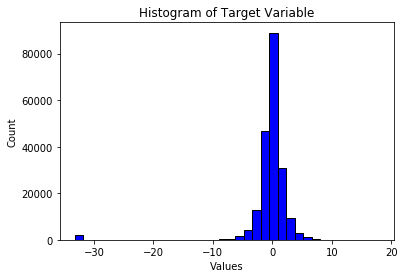

In [44]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(train['target'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))


# Add labels
plt.title('Histogram of Target Variable')
plt.xlabel('Values')
plt.ylabel('Count')

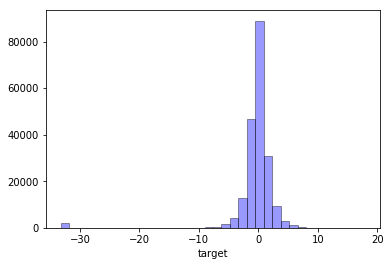

In [45]:
# seaborn histogram
sns.distplot(train['target'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [58]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()


0    199710
1      2207
Name: outliers, dtype: int64

### Saving the results

In [59]:
os.makedirs('tmp', exist_ok=True)
train.to_feather('tmp/train-elo')
test.to_feather('tmp/test-elo')

In [6]:
train = pd.read_feather('tmp/train-elo')

C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [7]:
scores = pd.read_feather('tmp/scores_df')

In [18]:
imp=scores[scores['gain_score']>0]['feature']

In [8]:
imp2=scores[scores['split_score']>0]['feature']; len(imp2)

114

### Train/validation split

Extract the atrget variable

In [9]:
df = train.drop(['target', 'card_id', 'outliers'], axis=1)
y = train.target

In [74]:
#the ratio between test set and train set
len(test)/len(train)

0.6122466161838775

**1st approach**

In [79]:
#split the dataset using n firts observations for train set and the rest for validation set
def split_vals(a,n): return a[:n], a[n:]

#set the size of validation set equal to test set
n_valid = len(test)
n_trn = len(train)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)


**2nd approach**

In [8]:
# create training and validation sets using 20% of random records for validation set
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(161533, 313) (161533,)
(40384, 313) (40384,)


In [9]:
del train
gc.collect()

7

In [77]:
#to easily acess the recods for prediction
X_valid.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)

### Evaluation

In [10]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

# print rmse for train and validation set, r2 for train and validation set and oob score if there is one calculated
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Random Forest

In [64]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[1.6794789616877408, 4.015497903835961, 0.8082370546494724, -0.05421541843513578]


The RMSE for train set is much lower than for the validation set -> the model is overfitted

#### OOB score

In [65]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, 
                          oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.468986364995188, 3.8438377887525967, 0.8532929159572622, 0.033992138765430946, -0.033637532801900294]


### Subsampling

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(161533, 92) (161533,)
(40384, 92) (40384,)


In [61]:
set_rf_samples(20000)

In [62]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 23.2 s
[3.527450520186248, 3.9363047237306965, 0.1611936356136363, -0.04727618112366794, -0.06205179981917652]


In [63]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=20, 
                          n_jobs=-1, oob_score=True) 
m.fit(X_train, y_train) 
print_score(m)

[3.6159834632469656, 3.707170403273028, 0.11856005655933656, 0.0711001305210156, 0.07717011918000038]


### Max feature

In [64]:
reset_rf_samples()

In [10]:
df=df[imp2]

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(161533, 114) (161533,)
(40384, 114) (40384,)


In [12]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=25, 
                      max_features=25, n_jobs=-1, oob_score=True) 
m.fit(X_train, y_train) 
print_score(m)

NameError: name 'print_score' is not defined

## Correlations

In [42]:
corr_df = df.corr(method='pearson')

In [43]:
corr_df.head()

,feature_1,feature_2,feature_3,elapsed_time,nonauth_transactions_count,nonauth_category_1_sum,nonauth_category_1_mean,nonauth_merchant_id_nunique,nonauth_merchant_category_id_nunique,nonauth_state_id_nunique,...,new_state_id_std_na,new_city_id_std_na,new_subsector_id_std_na,new_purchase_amount_std_na,new_purchase_amount_skew_na,new_installments_std_na,category_1_purchase_amount_std_na,installments_purchase_amount_std_na,city_id_purchase_amount_std_na,category_1_installments_std_na
feature_1,1.000000,-0.130969,0.583092,0.117144,0.077003,0.004782,-0.020341,0.105148,0.096107,0.049733,...,0.025113,0.025113,0.025113,0.025113,0.025589,0.025113,0.041611,0.026733,0.009941,0.041611
feature_2,-0.130969,1.000000,0.060925,0.158150,0.011970,-0.030345,-0.082894,0.031990,0.023115,-0.019295,...,0.026345,0.026345,0.026345,0.026345,0.032849,0.026345,0.102719,0.114217,0.050326,0.102719
feature_3,0.583092,0.060925,1.000000,0.196046,0.079343,-0.008028,-0.080649,0.112444,0.100982,0.054667,...,0.044173,0.044173,0.044173,0.044173,0.055677,0.044173,0.167796,0.233698,0.071707,0.167796
elapsed_time,0.117144,0.158150,0.196046,1.000000,0.105719,0.035902,-0.027509,0.131043,0.125118,0.044530,...,0.121745,0.121745,0.121745,0.121745,0.135591,0.121745,0.109550,0.135552,0.109909,0.109550
nonauth_transactions_count,0.077003,0.011970,0.079343,0.105719,1.000000,0.676534,0.118762,0.687219,0.660811,0.374751,...,-0.018861,-0.018861,-0.018861,-0.018861,-0.027051,-0.018861,0.031098,0.057407,-0.021397,0.031098


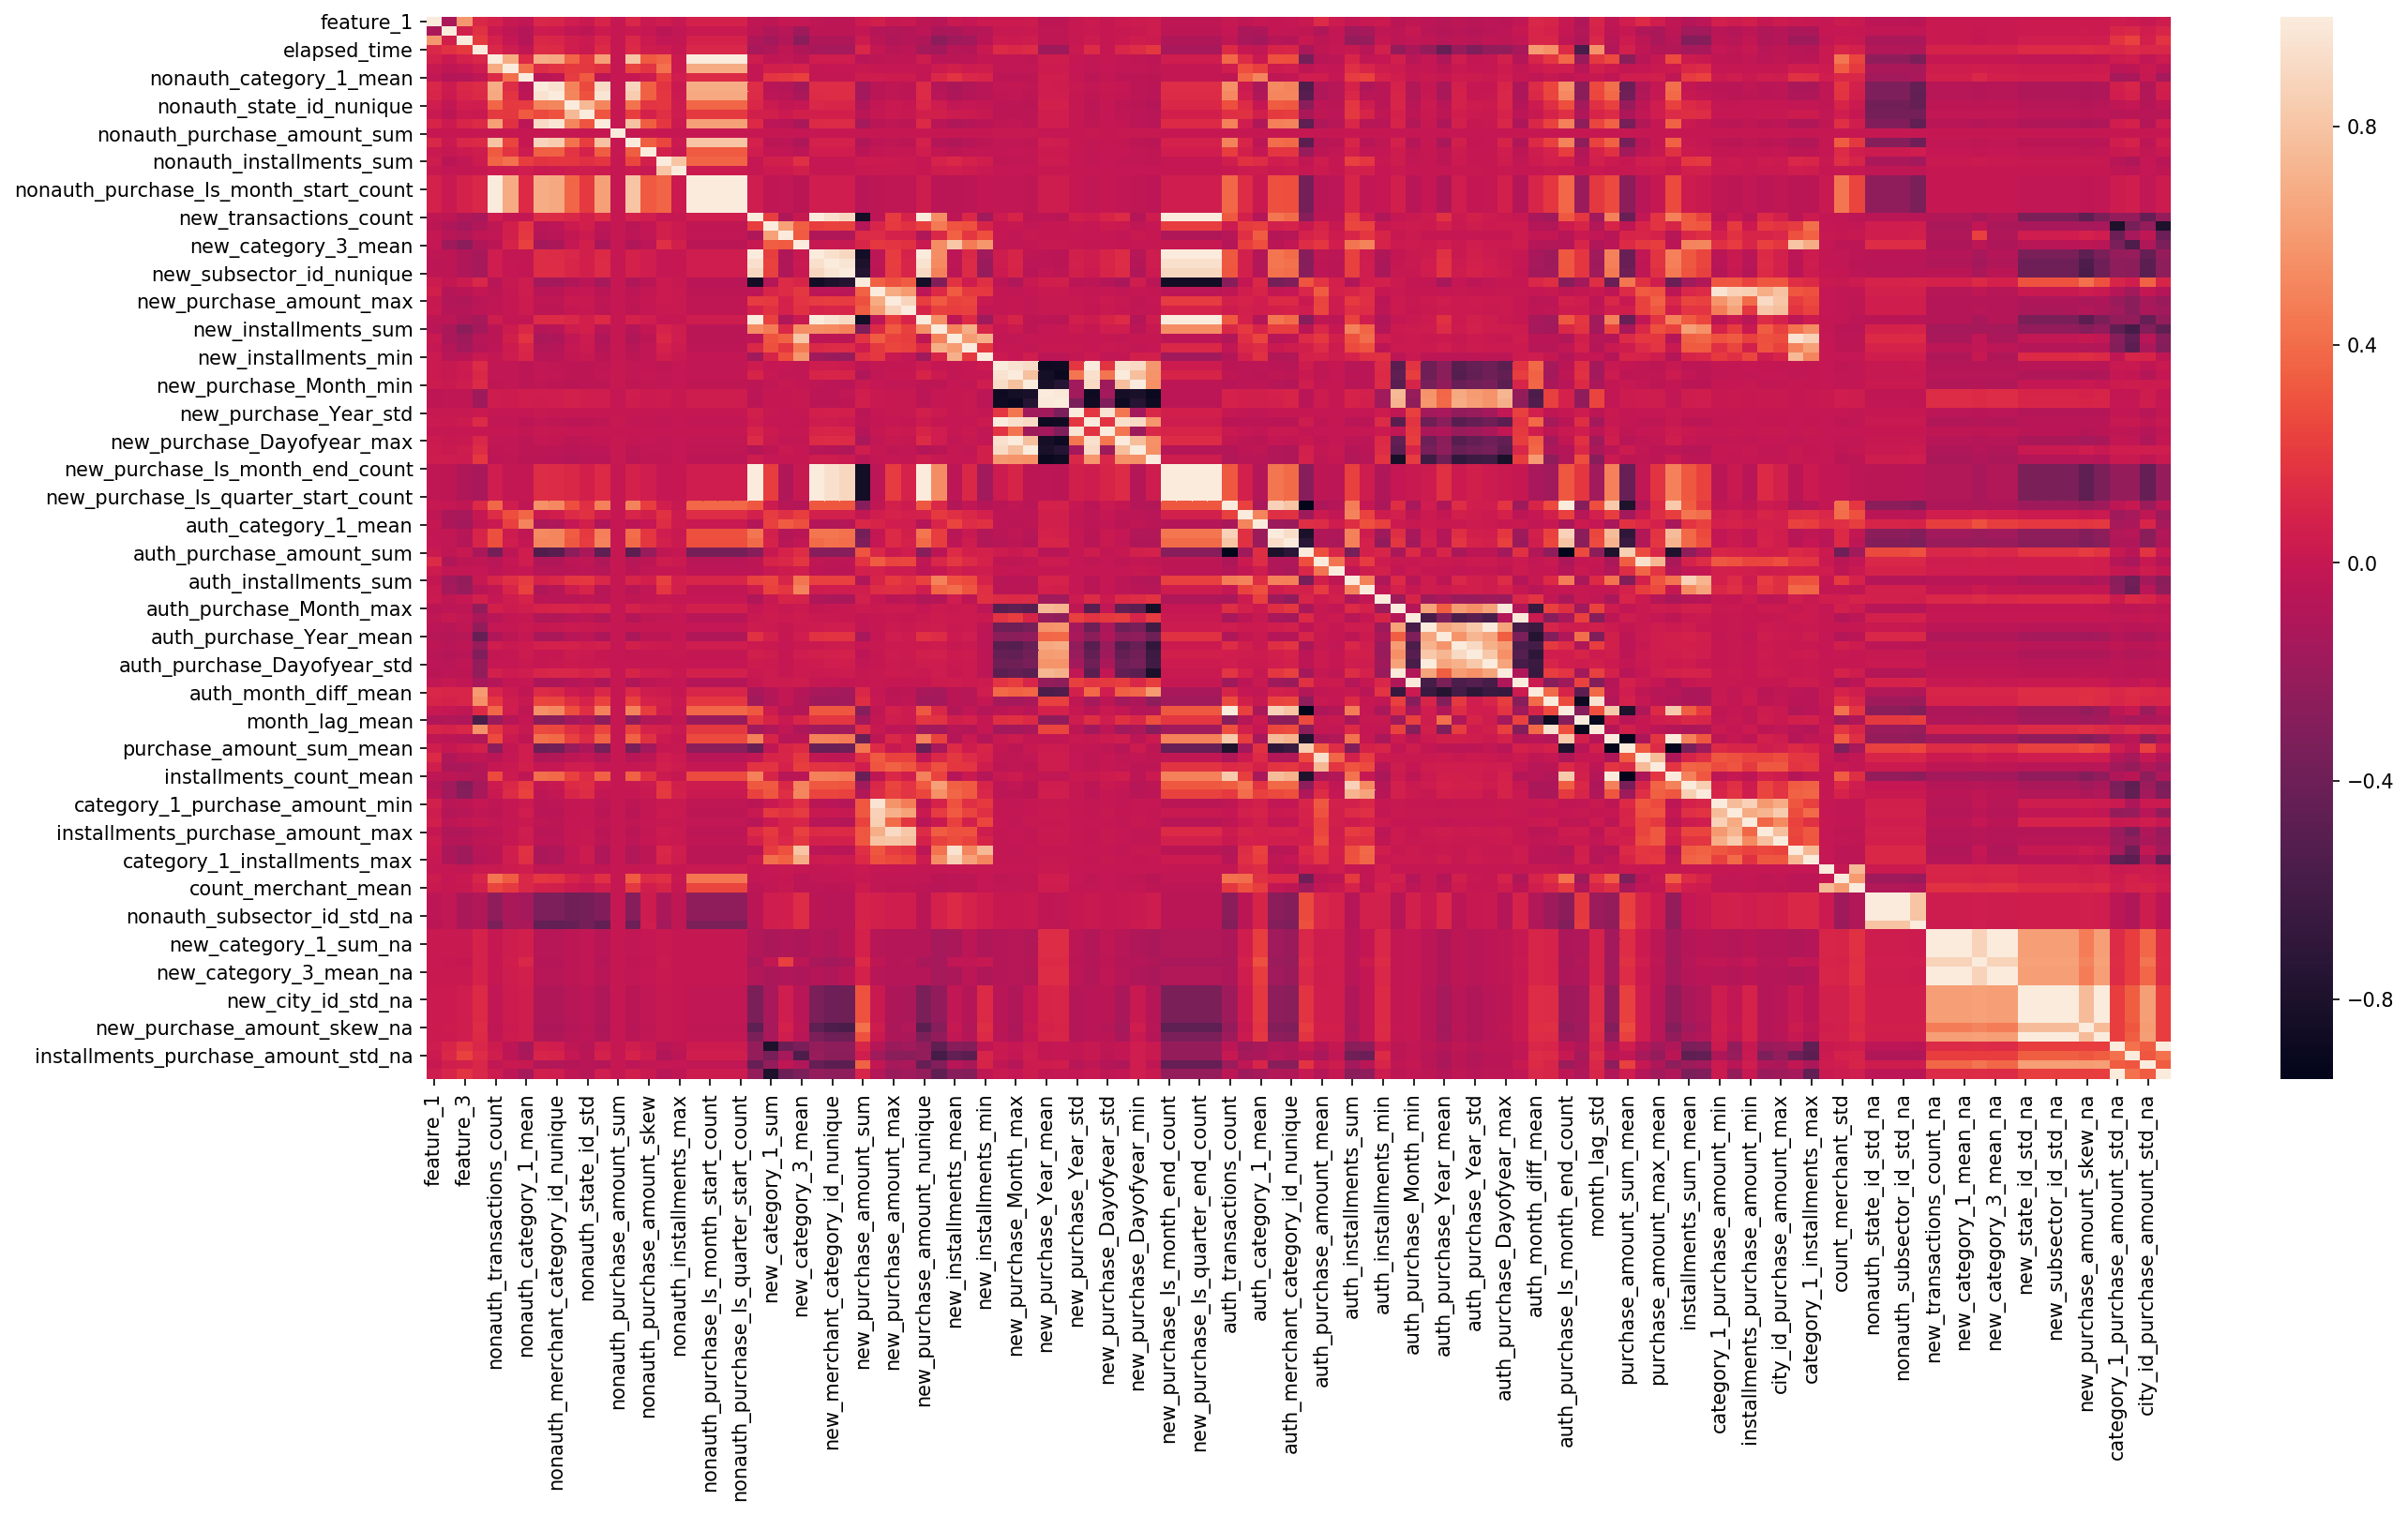

In [50]:
import seaborn 
plt.figure(figsize=(20,10), dpi=150)
seaborn.heatmap(corr_df)

plt.yticks(rotation=0) 

plt.xticks(rotation=90) 

plt.show()

In [51]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [52]:
to_drop

['nonauth_merchant_category_id_nunique',
 'nonauth_subsector_id_nunique',
 'nonauth_purchase_Is_month_end_count',
 'nonauth_purchase_Is_month_start_count',
 'nonauth_purchase_Is_quarter_end_count',
 'nonauth_purchase_Is_quarter_start_count',
 'new_merchant_id_nunique',
 'new_subsector_id_nunique',
 'new_purchase_amount_nunique',
 'new_purchase_Year_min',
 'new_purchase_Dayofyear_mean',
 'new_purchase_Dayofyear_std',
 'new_purchase_Dayofyear_max',
 'new_purchase_Dayofyear_min',
 'new_purchase_Is_month_end_count',
 'new_purchase_Is_month_start_count',
 'new_purchase_Is_quarter_end_count',
 'new_purchase_Is_quarter_start_count',
 'auth_purchase_Dayofyear_std',
 'auth_purchase_Dayofyear_max',
 'auth_purchase_Dayofyear_min',
 'auth_purchase_Is_month_end_count',
 'month_lag_std',
 'installments_count_mean',
 'category_1_purchase_amount_min',
 'category_1_installments_min',
 'nonauth_city_id_std_na',
 'nonauth_subsector_id_std_na',
 'new_category_1_sum_na',
 'new_category_1_mean_na',
 'new_ca

In [14]:
from scipy.cluster import hierarchy as hc

In [28]:
corr = np.round(scipy.stats.spearmanr(df[to_drop]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df[to_drop].columns, orientation='left', leaf_font_size=16)
plt.show()

NameError: name 'to_drop' is not defined

In [56]:
f=['nonauth_purchase_Is_quarter_end_count', 'nonauth_purchase_Is_month_start_count', 'nonauth_purchase_Is_month_end_count',
   'new_purchase_Is_quarter_end_count', 'new_purchase_Is_quarter_start_count', 'new_purchase_amount_nunique', 
   'nonauth_city_id_std_na', 'nonauth_subsector_id_std_na']

In [61]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=25, max_features=0.6, n_jobs=-1, oob_score=True)
    #x, _ = split_vals(df, n_trn)
    m.fit(df, y)
    return m.oob_score_

In [62]:
for c in f:
    print(c, get_oob(df.drop(c, axis=1)))

nonauth_purchase_Is_quarter_end_count 0.07252801949107135
nonauth_purchase_Is_month_start_count 0.07277899413269617
nonauth_purchase_Is_month_end_count 0.07153329306996148
new_purchase_Is_quarter_end_count 0.07226287745486826
new_purchase_Is_quarter_start_count 0.07333054733948752
new_purchase_amount_nunique 0.07415629380804434
nonauth_city_id_std_na 0.06935296700467453
nonauth_subsector_id_std_na 0.07138895350777452


In [63]:
#baseline
get_oob(df)

C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.06897354199398875

In [64]:
to_drop = ['nonauth_purchase_Is_quarter_end_count', 'nonauth_purchase_Is_month_start_count', 'new_purchase_Is_quarter_start_count', 'new_purchase_amount_nunique','nonauth_subsector_id_std_na']
get_oob(df.drop(to_drop, axis=1))

0.07098718406038063

In [15]:
#corr - macierz korelacji
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
#corr_condensed
corr_condensed = hc.distance.squareform(1-corr)
#The linkage function uses the distance information generated in step 1 to determine the proximity of objects to each other. 
#As objects are paired into binary clusters, the newly formed clusters are grouped into larger clusters until 
#a hierarchical tree is formed. 
z = hc.linkage(corr_condensed, method='average')
#fig = plt.figure(figsize=(30,10))
#dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
#plt.show()

In [36]:
# Create correlation matrix
corr_matrix = pd.DataFrame(np.round(scipy.stats.spearmanr(df).correlation, 4)).abs()
corr_matrix.columns=df.columns
corr_matrix['ind']=df.columns
corr_matrix.set_index('ind')
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [40]:
corr_matrix = pd.DataFrame(np.round(scipy.stats.spearmanr(df).correlation, 4)).abs()
corr_matrix.columns=df.columns
corr_matrix['ind']=df.columns
corr_matrix.set_index('ind', inplace=True)
corr_matrix.head()

,feature_1,feature_2,feature_3,elapsed_time,nonauth_transactions_count,nonauth_category_1_sum,nonauth_category_1_mean,nonauth_merchant_id_nunique,nonauth_merchant_category_id_nunique,nonauth_state_id_nunique,...,new_state_id_std_na,new_city_id_std_na,new_subsector_id_std_na,new_purchase_amount_std_na,new_purchase_amount_skew_na,new_installments_std_na,category_1_purchase_amount_std_na,installments_purchase_amount_std_na,city_id_purchase_amount_std_na,category_1_installments_std_na
ind,,,,,,,,,,,,,,,,,,,,,
feature_1,1.0000,0.0916,0.6332,0.1314,0.0668,0.0004,0.0082,0.0749,0.0685,0.0399,...,0.0260,0.0260,0.0260,0.0260,0.0254,0.0260,0.0470,0.0417,0.0135,0.0470
feature_2,0.0916,1.0000,0.0546,0.1476,0.0286,0.1000,0.1041,0.0496,0.0392,0.0167,...,0.0272,0.0272,0.0272,0.0272,0.0329,0.0272,0.1230,0.1496,0.0528,0.1230
feature_3,0.6332,0.0546,1.0000,0.1570,0.0965,0.0348,0.0535,0.1133,0.0964,0.0568,...,0.0442,0.0442,0.0442,0.0442,0.0557,0.0442,0.1678,0.2337,0.0717,0.1678
elapsed_time,0.1314,0.1476,0.1570,1.0000,0.1745,0.0191,0.0006,0.1964,0.1788,0.0831,...,0.1439,0.1439,0.1439,0.1439,0.1597,0.1439,0.1293,0.1671,0.1260,0.1293
nonauth_transactions_count,0.0668,0.0286,0.0965,0.1745,1.0000,0.2779,0.1781,0.8717,0.8531,0.4599,...,0.0395,0.0395,0.0395,0.0395,0.0491,0.0395,0.0443,0.0761,0.0367,0.0443


In [41]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [57]:
# create a list of tuples for correlated columns
res = [(col,)+ tuple(val[val>0.99].index) for col, val in upper.iteritems() if any(val>0.99)]

In [58]:
res

[('nonauth_purchase_Is_month_end_count', 'nonauth_transactions_count'),
 ('nonauth_purchase_Is_month_start_count',
  'nonauth_transactions_count',
  'nonauth_purchase_Is_month_end_count'),
 ('nonauth_purchase_Is_quarter_end_count',
  'nonauth_transactions_count',
  'nonauth_purchase_Is_month_end_count',
  'nonauth_purchase_Is_month_start_count'),
 ('nonauth_purchase_Is_quarter_start_count',
  'nonauth_transactions_count',
  'nonauth_purchase_Is_month_end_count',
  'nonauth_purchase_Is_month_start_count',
  'nonauth_purchase_Is_quarter_end_count'),
 ('new_category_1_mean', 'new_category_1_sum'),
 ('new_merchant_id_nunique', 'new_transactions_count'),
 ('new_purchase_amount_nunique',
  'new_transactions_count',
  'new_merchant_id_nunique'),
 ('new_purchase_Year_min', 'new_purchase_Year_mean'),
 ('new_purchase_Is_month_end_count',
  'new_transactions_count',
  'new_merchant_id_nunique',
  'new_purchase_amount_nunique'),
 ('new_purchase_Is_month_start_count',
  'new_transactions_count',
  

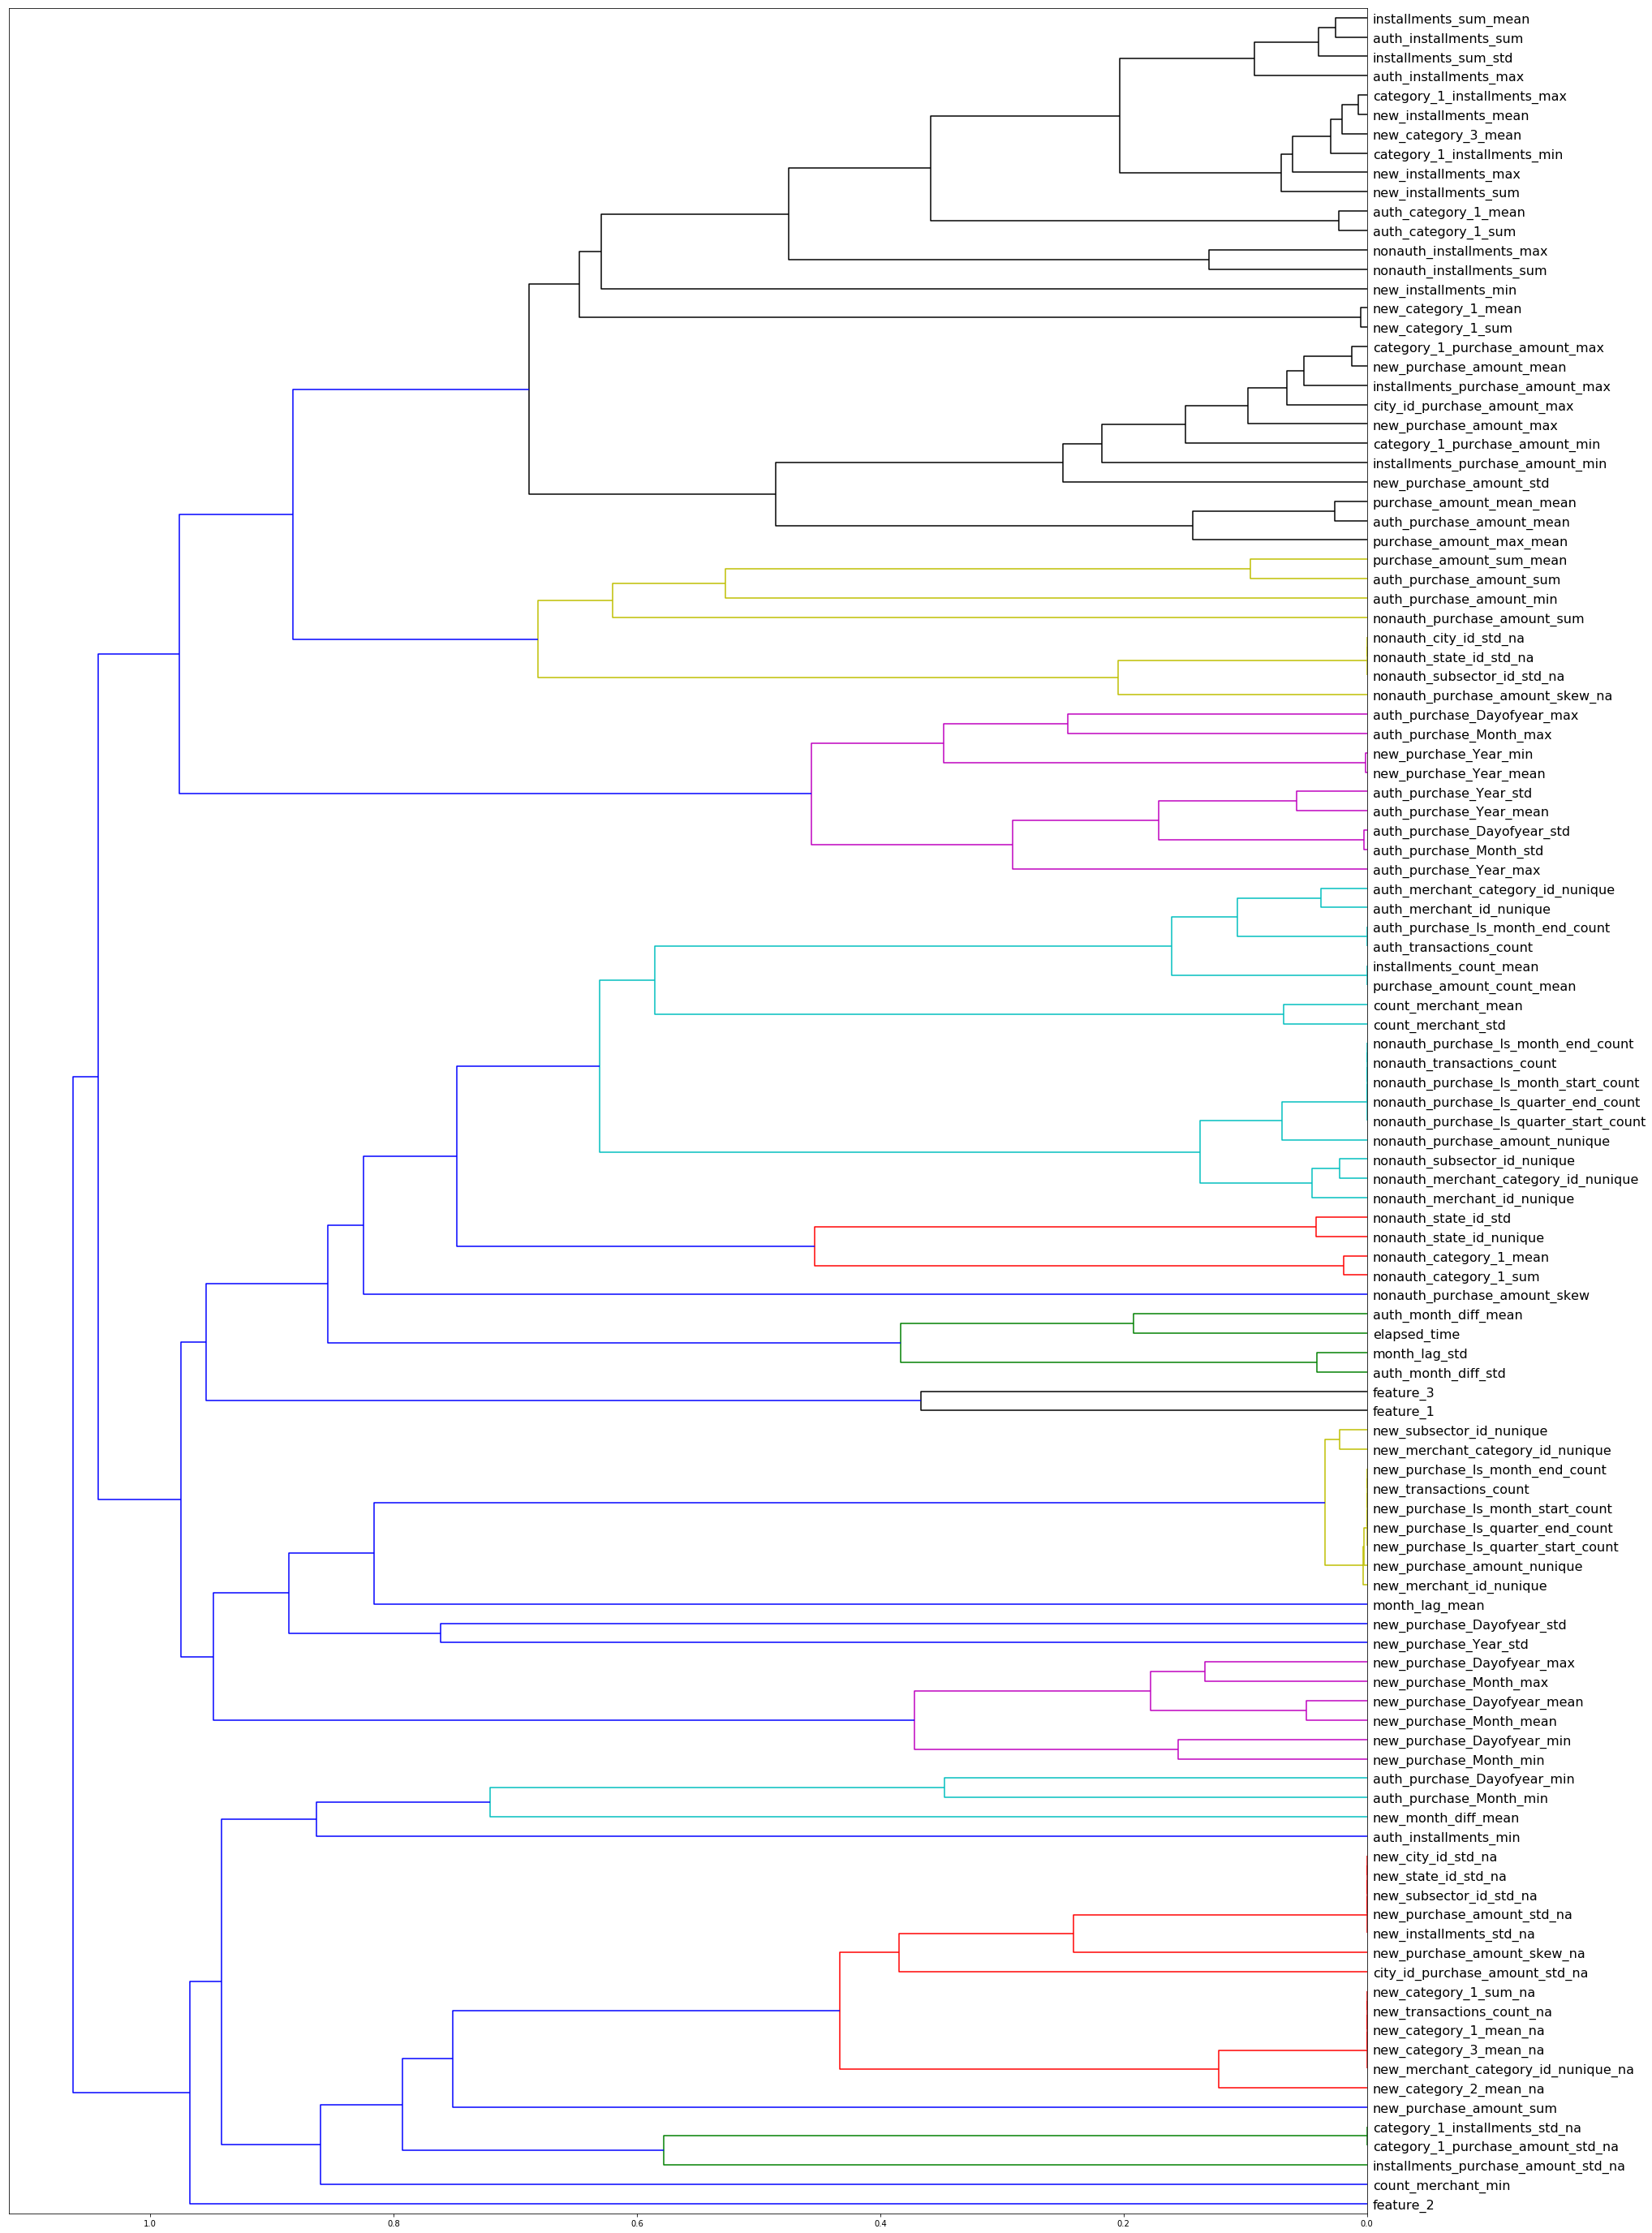

In [68]:
fig = plt.figure(figsize=(30,50))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

In [ ]:
f2=['category_1_installments_std_na', 'category_1_purchase_amount_std_na',
   'new_transactions_count_na']

## Final Model

In [13]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(df), y), m.score(df, y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

[3.4336059622484445, 0.2048138535973162, 0.0856303937273426]


In [19]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=30, max_features=25, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)


[3.4594775383761536, 3.6246156075123186, 0.19891827037811494, 0.08587319891312317, 0.07757077634794296]


## Feature importance

In [27]:
len(m.feature_importances_)

189

In [28]:
fi = rf_feat_importance(m, df); fi

,cols,imp
113,auth_purchase_Year_mean,2.117244e-02
76,new_purchase_Dayofyear_max,1.926576e-02
85,auth_category_1_sum,1.850788e-02
78,new_month_diff_mean,1.821383e-02
86,auth_category_1_mean,1.572779e-02
74,new_purchase_Dayofyear_mean,1.479277e-02
65,new_purchase_Month_mean,1.437351e-02
75,new_purchase_Dayofyear_std,1.379801e-02
56,new_purchase_amount_max,1.376715e-02
5,nonauth_category_1_sum,1.351322e-02


In [29]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,20), legend=False)

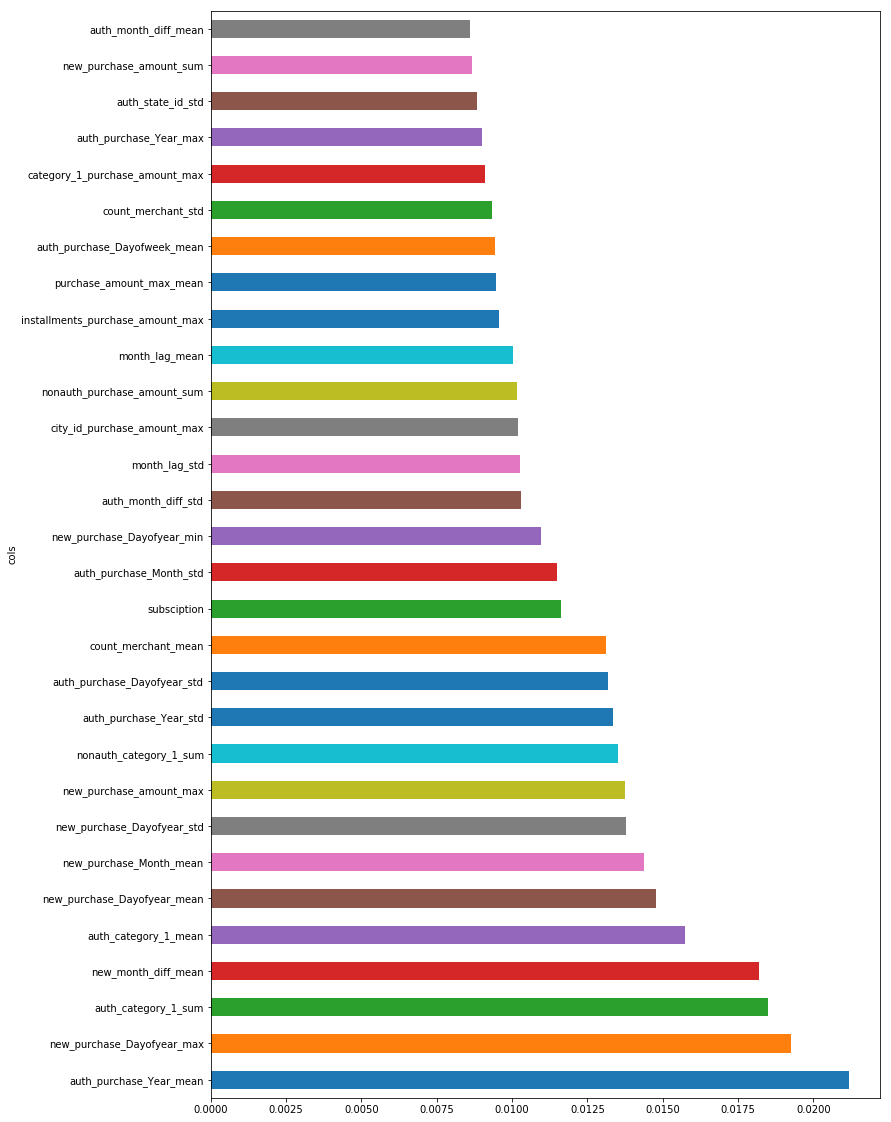

In [30]:
plot_fi(fi[:30]);

In [84]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

77

In [87]:
to_keep2 = fi[fi.imp>0.0005].cols; len(to_keep2)

210

### Keeping only important features

In [88]:
df_keep = df[to_keep2].copy()
X_train, X_valid, y_train, y_valid = train_test_split(df_keep, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(161533, 210) (161533,)
(40384, 210) (40384,)


In [89]:
# print rmse for train and validation set, r2 for train and validation set and oob score if there is one calculated
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [95]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=25, max_features=25,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=25, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=25,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [96]:
print_score(m)

[3.3731978690682225, 3.7345931094687446, 0.23011991616955707, 0.07100949727597783, 0.08211658013714673]


Compare it to the results for the dataset with all the variables: [3.3999518962067286, 3.694610993460959, 0.22073458706157834, 0.07738345213270315, 0.07946947881653244], 

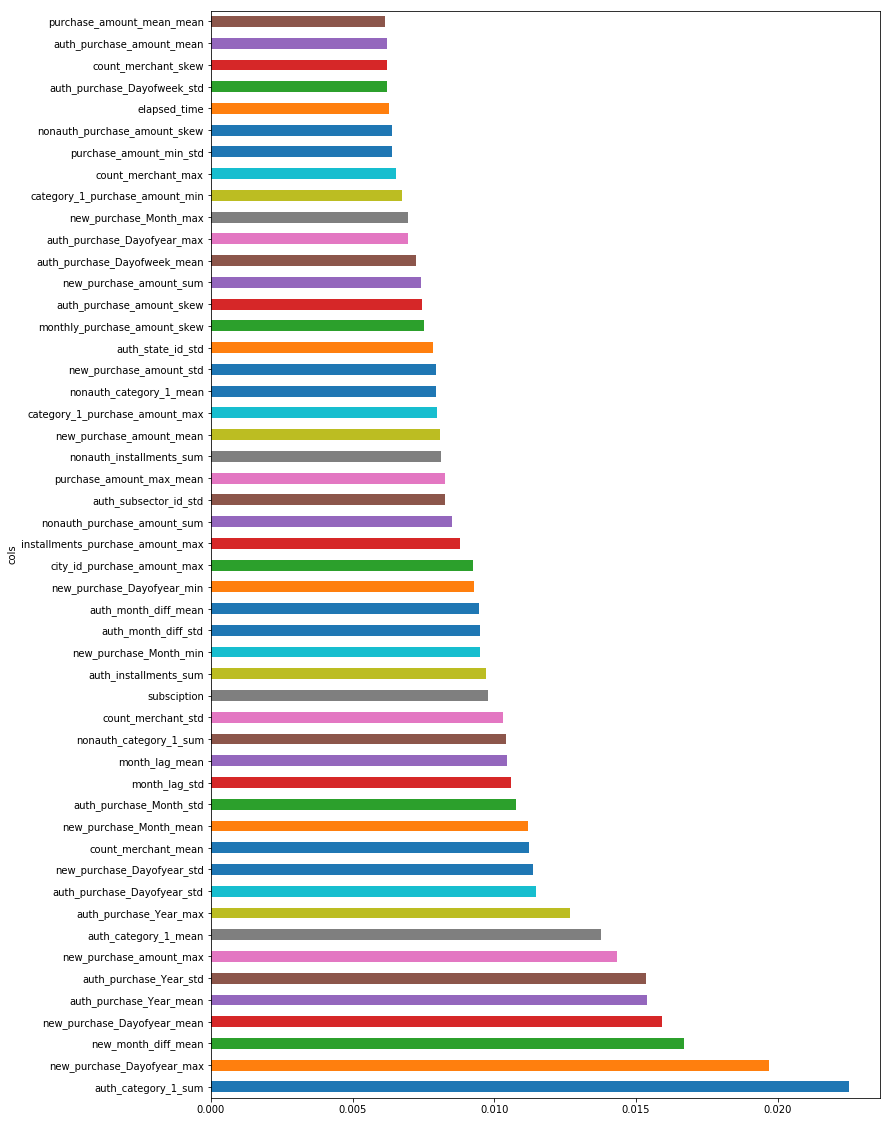

In [104]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:50]);

In [105]:
fi[:30]

,cols,imp
2,auth_category_1_sum,0.022505
1,new_purchase_Dayofyear_max,0.019714
0,new_month_diff_mean,0.016697
3,new_purchase_Dayofyear_mean,0.015938
4,auth_purchase_Year_mean,0.015393
7,auth_purchase_Year_std,0.015348
9,new_purchase_amount_max,0.014333
8,auth_category_1_mean,0.013786
5,auth_purchase_Year_max,0.012659
12,auth_purchase_Dayofyear_std,0.011464


Experimenting with number of estimators

In [106]:
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=25, max_features=30,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[3.3616714113599295, 3.7309517616197194, 0.2353723970745147, 0.07282020506209208, 0.08539409209341764]


Experimenting with set_rf_samples

In [101]:
set_rf_samples(20000)
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=25, max_features=30,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[3.642384705426545, 0.1051720851660688, 0.08148243328041815]


### XGBoost

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(161533, 277) (161533,)
(40384, 277) (40384,)


In [53]:
data_dmatrix = xgb.DMatrix(data=df,label=y)

**Hyperparameters**

objective":"reg:linear" - determines the loss function

'colsample_bytree': 0.3 - percentage of features used per tree. High value can lead to overfitting.

'learning_rate': 0.1 - step size shrinkage used to prevent overfitting. Range is [0,1]

'max_depth': 5 - how deeply each tree is allowed to grow during any boosting round

'alpha': 10 - L1 regularization on leaf weights. A large value leads to more regularization


nfold=3 - number of cross validation sets

num_boost_round=50 - the number of trees

early_stopping_rounds=10 - finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds

metrics="rmse" - evaluation metrics to be watched during CV

as_pandas=True - to return the results in a pandas DataFrame

seed=123 -  for reproducibility of results

In [54]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

#3-fold cross validation model by invoking XGBoost's cv() method and store the results in a cv_results DataFrame
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[13:33:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:33:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[13:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[13:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5


In [55]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [58]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [61]:
print_score(xg_reg)

[3.733357959410553, 3.7339709255700577, 0.0612192934171547, 0.054350288205652575]


In [71]:
# feature importance
sorted_idx = np.argsort(xg_reg.feature_importances_)[::-1]

for index in sorted_idx:
    print([df.columns[index], xg_reg.feature_importances_[index]]) 


['new_purchase_amount_std', 0.048543688]
['new_purchase_amount_max', 0.042071197]
['new_purchase_Dayofyear_std', 0.042071197]
['nonauth_category_1_sum', 0.029126214]
['month_lag_std', 0.029126214]
['new_purchase_Dayofyear_mean', 0.025889968]
['nonauth_purchase_amount_sum', 0.022653721]
['auth_month_diff_mean', 0.022653721]
['new_purchase_amount_std_na', 0.019417476]
['city_id_purchase_amount_max', 0.019417476]
['nonauth_purchase_Is_month_end_count', 0.01618123]
['new_purchase_Month_mean', 0.01618123]
['new_purchase_amount_sum', 0.01618123]
['new_purchase_amount_min', 0.01618123]
['auth_purchase_amount_sum', 0.01618123]
['count_merchant_mean', 0.01618123]
['installments_purchase_amount_min', 0.01618123]
['auth_installments_sum', 0.01618123]
['auth_category_1_sum', 0.01618123]
['new_purchase_Month_std', 0.01618123]
['auth_purchase_Year_mean', 0.012944984]
['new_purchase_Month_max', 0.012944984]
['auth_purchase_amount_max', 0.012944984]
['nonauth_transactions_count', 0.012944984]
['new_pu

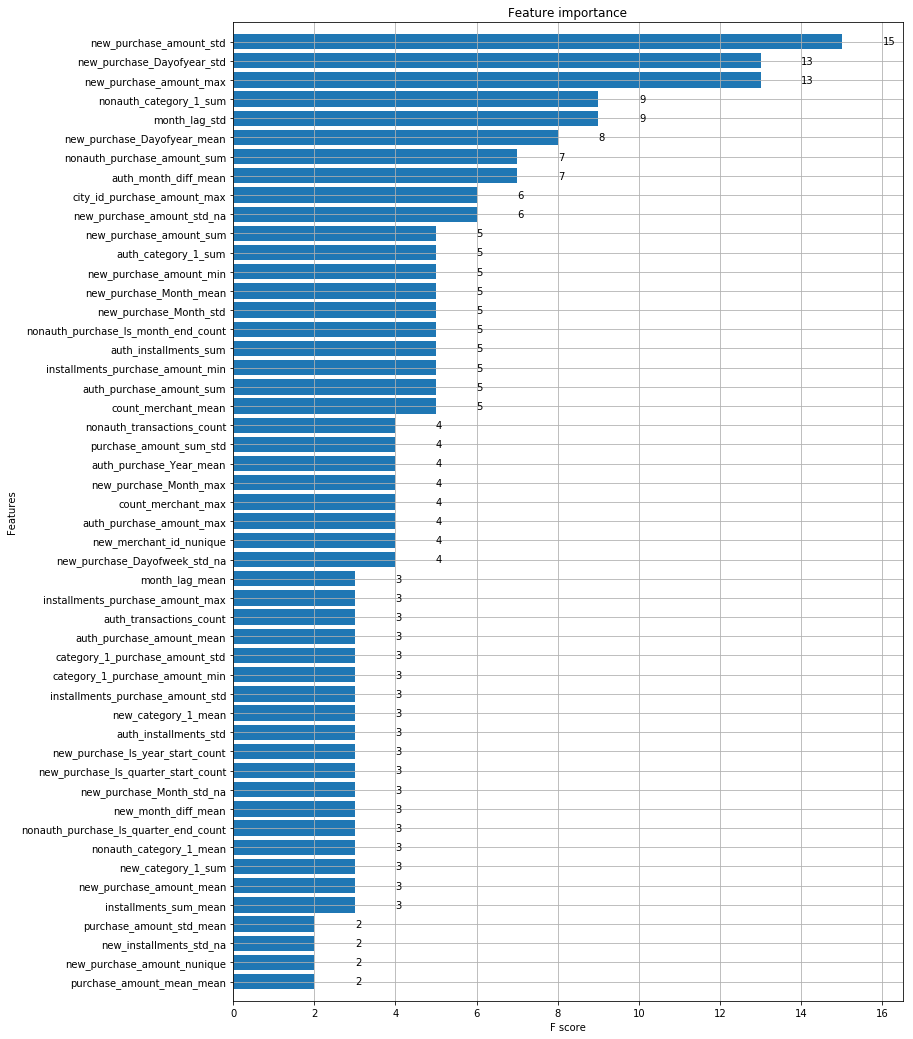

In [69]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xg_reg, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Light GMB

In [122]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [117]:
param = {'objective':'regression',
         'num_leaves': 31,
         'min_data_in_leaf': 25,
         'max_depth': 7,
         'learning_rate': 0.01,
         'lambda_l1':0.13,
         "boosting": "gbdt",
         "feature_fraction":0.85,
         'bagging_freq':8,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "verbosity": -1,
         "random_state": 2333}

In [123]:
df = train.drop(['target', 'card_id', 'outliers'], axis=1)
y = train.target
features = [c for c in df.columns]

In [ ]:
#model the data without ouliers
df = train[train['outliers'] == 0].drop(['target', 'card_id', 'outliers'], axis=1)
target = df_train['target']

In [124]:
t_data = df
features = [c for c in t_data.columns]


In [125]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(t_data.values, y.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(t_data.iloc[trn_idx][features],
                           label=y.iloc[trn_idx],
                           #categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(t_data.iloc[val_idx][features],
                           label=y.iloc[val_idx],
                           #categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(t_data.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, y)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72707	valid_1's rmse: 3.7892
[200]	training's rmse: 3.66268	valid_1's rmse: 3.74588
[300]	training's rmse: 3.62197	valid_1's rmse: 3.72412
[400]	training's rmse: 3.59245	valid_1's rmse: 3.71219
[500]	training's rmse: 3.57147	valid_1's rmse: 3.70583
[600]	training's rmse: 3.5541	valid_1's rmse: 3.70147
[700]	training's rmse: 3.54016	valid_1's rmse: 3.69845
[800]	training's rmse: 3.52856	valid_1's rmse: 3.69622
[900]	training's rmse: 3.51777	valid_1's rmse: 3.69503
[1000]	training's rmse: 3.50753	valid_1's rmse: 3.69387
[1100]	training's rmse: 3.49687	valid_1's rmse: 3.693
[1200]	training's rmse: 3.48709	valid_1's rmse: 3.69237
[1300]	training's rmse: 3.47775	valid_1's rmse: 3.69173
[1400]	training's rmse: 3.4685	valid_1's rmse: 3.69124
[1500]	training's rmse: 3.45949	valid_1's rmse: 3.69098
[1600]	training's rmse: 3.45146	valid_1's rmse: 3.69107
[1700]	training's rmse: 3.4427	valid_1's rmse:

In [115]:
print("CV score: {:<8.5f}".format(rmse(oof, y)))

CV score: 3.68652 


C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


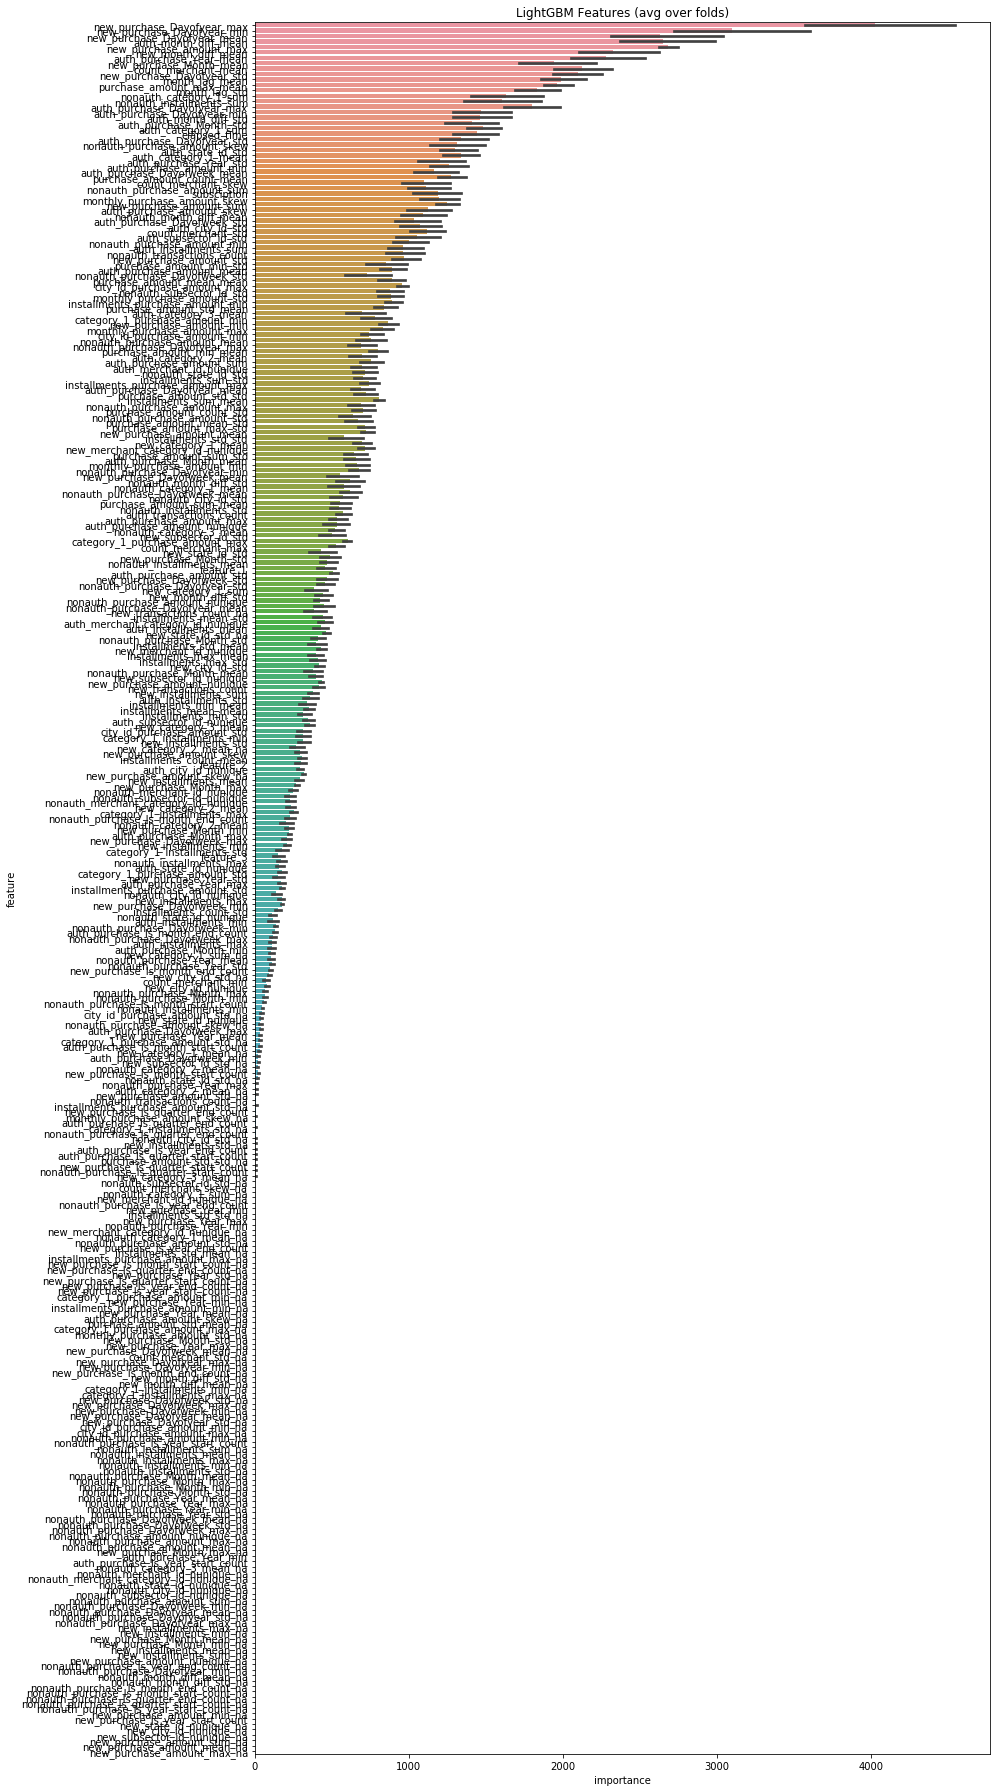

In [127]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()


In [129]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

In [ ]:
model_without_outliers = pd.DataFrame({"card_id":df_test["card_id"].values})
model_without_outliers["target"] = predictions

In [126]:
# model for ouliers

In [ ]:
target = train['outliers']


In [ ]:
param = {'objective':'regression',
         'num_leaves': 31,
         'min_data_in_leaf': 25,
         'max_depth': 7,
         'learning_rate': 0.01,
         'lambda_l1':0.13,
         "boosting": "gbdt",
         "feature_fraction":0.85,
         'bagging_freq':8,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "verbosity": -1,
         "random_state": 2333}

In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(t_data.values, y.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(t_data.iloc[trn_idx][features],
                           label=y.iloc[trn_idx],
                           #categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(t_data.iloc[val_idx][features],
                           label=y.iloc[val_idx],
                           #categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(t_data.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, y)**0.5))

In [ ]:


### 'target' is the probability of whether an observation is an outlier
df_outlier_prob = pd.DataFrame({"card_id":df_test["card_id"].values})
df_outlier_prob["target"] = predictions
df_outlier_prob.head()



In [ ]:


# In case missing some predictable outlier, we choose top 25000 with highest outliers likelyhood.
outlier_id = pd.DataFrame(df_outlier_prob.sort_values(by='target',ascending = False).head(25000)['card_id'])



In [ ]:
best_submission = pd.read_csv('../input/predicting-outliers-to-improve-your-score/3.695.csv')

In [ ]:


most_likely_liers = best_submission.merge(outlier_id,how='right')
most_likely_liers.head()



In [ ]:


model_without_outliers.to_csv("combining_submission.csv", index=False)



## Final Model

In [94]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(df_keep), y), m.score(df_keep, y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
reset_rf_samples()

In [95]:
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=30, 
                      max_features=25, n_jobs=-1, oob_score=True) 
m.fit(df_keep, y) 
print_score(m)

[3.394745913096457, 0.22271113781167595, 0.08800315745768195]


## Submission

In [6]:
test = pd.read_feather('tmp/test-elo')

In [97]:
print(f'Number of rows and columns in test set {test.shape}')

Number of rows and columns in test set (123623, 279)


In [98]:
#predictions = m.predict(test.drop(['card_id', 'elapsed_time_na'], axis=1))

In [99]:
predictions = m.predict(test[to_keep])

In [100]:
sub_df = pd.DataFrame({"card_id":test['card_id'],'target':predictions})

sub_df.to_csv("submission.csv", index=False)
